# Beslutningstrær

La oss fortsette med det klassiske datasettet som inneholder data om størrlsen (lengde og bredde) av begerbladene (engelsk: sepal) (de ytre bladene i en blomst) og kronbladene (engelsk: petal) til tre ulike typer Iris (setosa, versicolor og virginica) - på norsk hhv.: vill iris, praktiris og blått flagg iris. Vi skal bruke dette datasettet til å se nærmere på beslutningstrær. Først må vi importere noen pakker og lese inn datasettet.

Dette er helt identisk med det vi gjorde for lineær og logistisk regresjons så kan enkelt kopieres derfra.

In [1]:
from sklearn.datasets import load_iris

In [2]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#%matplotlib notebook
import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.stats import expon
import math

Vi må også importere beslutningstre-klassen fra scikit learn

In [3]:
from sklearn import tree

In [4]:
from sklearn import datasets
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0

Nå er typen iris lagret som 0, 1 og 2. Vi vil gjerne oversette dette til faktiske navn slik at vi ikke glemmer hva de ulike tallene betyr. Dette kan vi gjøre på flere måter, men en mulighet er å bruke såkalte lambda-funksjoner som utfører en test av hvert enkelt element in en kolonne. 

In [5]:
df['species'] = df['target'].apply(lambda x: "setosa" if x == 0.0 else ("versicolor" if x == 1.0 else "virginica"))

Det er keitete å ha kolonnenavn som inneholder mellomrom så la oss lage nye enklere navn. Når vi setter *inplace=True* betyr det at data-framen df automatisk blir oppdatert med de nye kolonnenavnene. Hvis ikke må man bruke *df = df.rename()* for at endringene skal bli oppdatert.

In [6]:
df.rename({'sepal length (cm)': 'sepal_length'}, axis='columns',inplace=True)
df.rename({'sepal width (cm)': 'sepal_width'}, axis='columns',inplace=True)
df.rename({'petal length (cm)': 'petal_length'}, axis='columns',inplace=True)
df.rename({'petal width (cm)': 'petal_width'}, axis='columns',inplace=True)
df.head()

sepal_length  sepal_width  petal_length  petal_width  target species
0           5.1          3.5           1.4          0.2     0.0  setosa
1           4.9          3.0           1.4          0.2     0.0  setosa
2           4.7          3.2           1.3          0.2     0.0  setosa
3           4.6          3.1           1.5          0.2     0.0  setosa
4           5.0          3.6           1.4          0.2     0.0  setosa

## Beslutningstrær for klassifikasjon

Vi så i tilfellene med logistisk regresjon at vi klarte å lage en ganske god modell, som med stor grad av sikkerhet kunne si, basert på målingere av bladene, hvilken iris vi ser på. Behovet for å komplisere ting ytterligere er dermed nødvendigvis ikke så stort, men vi vil allikevel bruke iris-datasettet til å illustrere en del egenskaper ved det å bruke beslutningstrær til klassifikasjon (og senere regresjon). 

Vi starter med å bruke [sckikit-learn sin implementering av beslutningstrær](https://scikit-learn.org/stable/modules/tree.html). Den tar en rekke input-parameter, men vi skal her fokusere mest på dybden til treet. Altså, hvor mange grener den får lov til å bruke for å splitte dataene.

In [7]:
clf = tree.DecisionTreeClassifier(max_depth=2)

Vi bruker samme innput som for multinomisk logistisk regresjon (alle predikatorene og alle kategoriene (iris-typene))

In [8]:
# Lage en liste med navnene til alle predikatorene
predictors = ["sepal_length","sepal_width","petal_length","petal_width"]
# Nå ser vi på alle iris-typene også
X = df[predictors].values
Y = df.target.to_numpy()

In [9]:
clf = clf.fit(X, Y)

Beslutningstrærne kommer med innebygde funksjoner for å visulaisere hvordan treet ser ut når vi har trent det på dataene.

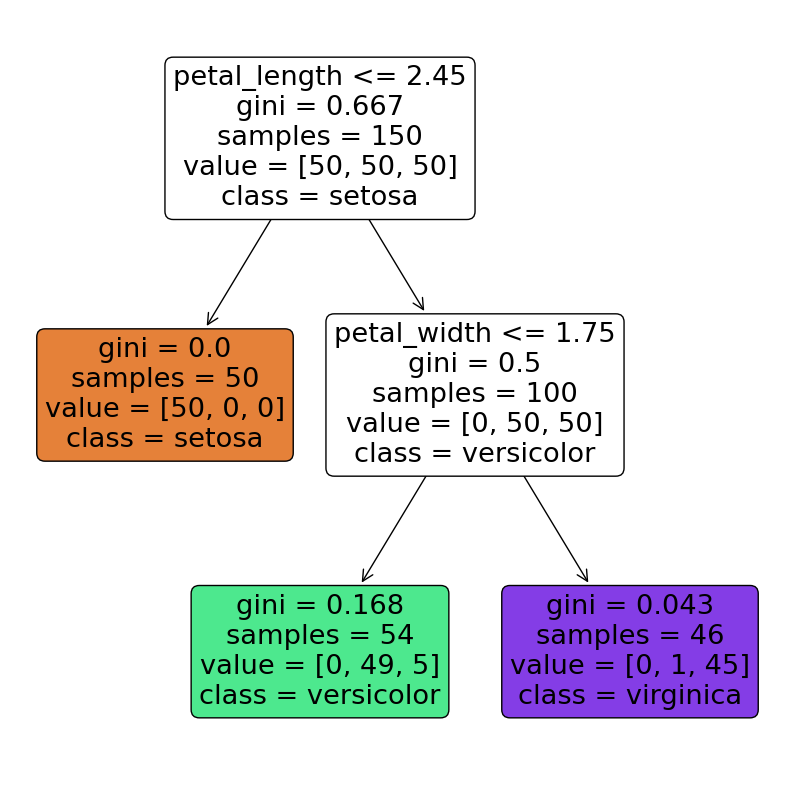

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
tree.plot_tree(clf, filled=True, class_names=df.species.unique().tolist(),feature_names=predictors,rounded=True);

De ulike fargene indikerer hvilken klasse (type iris) som er kategorisert i de ulike *terminalnodene/bladene* 

Med tredybde 2 ser den ut til å gjøre en perfekt utvelgelse av iris setosa allerede på første kutt: $petal\_length\leq 2.45$. Kuttet hjelper derimot ikke for å skille versicolor fra virginica. Men der brukes et nytt kutt i $petal\_width\leq 1.75$ La oss se om disse kuttene gir mening.

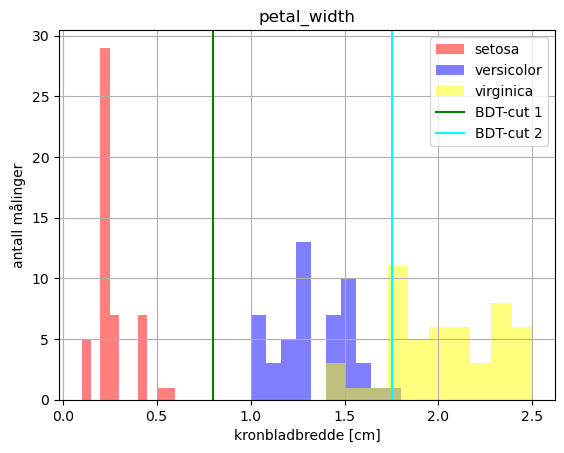

In [11]:
fig, ax = plt.subplots()
colors = {'setosa': 'red', 'versicolor': 'blue', 'virginica': 'yellow' }
for t in df['species'].unique():
    df[df["species"] == t].hist(column="petal_width",color=colors[t],ax=ax,label=t,alpha=0.5)
plt.axvline(x = 0.8,color="green",label="BDT-cut 1")
plt.axvline(x = 1.75,color="cyan",label="BDT-cut 2")
ax.set_title('petal_width')
ax.set_xlabel('kronbladbredde [cm]')
ax.set_ylabel('antall målinger')
plt.legend()

Vi ser at vi oppnår ganske god separasjon mellom du ulike typene iris bare ved å bruke en dypde på 2. Faktisk bruker da treet kun en variable til å oppnå ganske bra score. Det er jo det samme vi så med logistisk regresjon - at det å legge til flere predikatorer egentlig ikke gjorde modellene noe bedre. Før vi går videre kan vi se på hva som skjer dersom vi øker dypden på treet. Da vil vi nok se at det er begrenset hvor dypt treet kan bli med såpass får predikatorer og begrenset kompleksitet i datasettet.

Vi ser også at treet gir en verdi, *gini*, for hver node den lager i treet. Dette er en indeks som brukes til å bestemme den optimale måten å splitte treet på. Gini-indeksen, $G$, er gitt ved

$$G = \sum_{k=1}^{K}\hat{p}_{mk}\left(1-\hat{p}_{mk}\right)$$

Gini-indeksen er et mål på variasjonen i dataene og $\hat{p}_{mk}$ representerer delen av målinger i område $m$ som hører til klasse $k$. Klasse i dette tilfellet er de tre ulike typene iris. Vi kan enkelt reprodusere gini-indeksen til topp-noden siden det bare tilsvarer antall målinger vi har av hver enkelt iris (da det bare er ett område før datasettet splittes).

In [12]:
df.species.value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Det betyr at $\hat{p}_{mk} = 1/3$ for hver klasse. Hvis vi setter det inn i likningen får vi 
$$ G = 3*\frac{1}{3}\left(1-\frac{1}{3}\right) \approx 0.66$$

### Viktigheten til de ulike variablene 

Den tilpassede modellen kommer også med nyttige funksjoner for å få tak i vikitgheten av hver enkelt variabel/feature (*feature importance*). Vi kan hente dette ut fra modellen, sortere etter viktighet og plotte. I dette tilfellet betyr vikitghet den normaliserte reduksjonen av Gini-indeksen som hver enkelt variabel bidrar med.

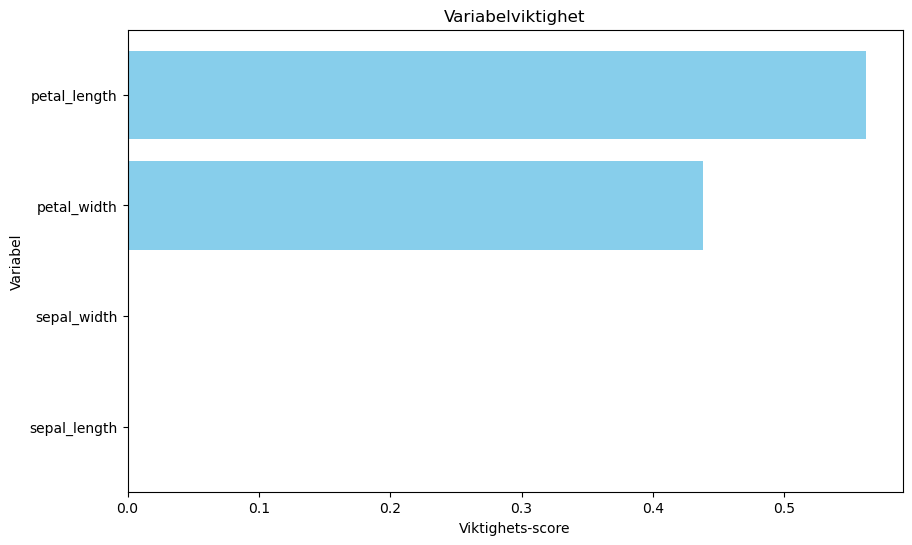

In [13]:
feature_names = predictors
importance_scores = clf.feature_importances_
# Sort the features by their importance scores
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices][::-1]
sorted_importance_scores = [importance_scores[i] for i in sorted_indices][::-1]

# Create a lying bar plot of the feature importance scores
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores, color='skyblue')
plt.title('Variabelviktighet')
plt.xlabel('Viktighets-score')
plt.ylabel('Variabel')
plt.show()

### Beslutningsoverflater

Etterhvert som treet gjør flere og flere kutt blir det mer komplisert å forstå i detalj hvilke beslutninger som blir tatt og hvordan treet definerer områdene. Spesielt vanskelig er det når vi har flere enn to predikatorer siden beslutningstreet reelt sett da gjør kutt i et hyperdimensjonalt rom. 

Med to predikatorer derimot kan vi relativt enkelt visualisere hva som foregår, så la oss se på to-og-to av predikatorene om gangen og lage en modell for disse. Vi kan da se på beslutningsområdet i 2 dimensjoner. 

In [14]:
from sklearn.inspection import DecisionBoundaryDisplay

/tmp/ipykernel_1898/2402788878.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_1898/2402788878.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5);
/tmp/ipykernel_1898/2402788878.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_1898/2402788878.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5);
/tmp/ipykernel_1898/2402788878.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/ipykernel_1898/2402788878.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5);
/tmp/ipykernel_1898/2402788878.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
/tmp/

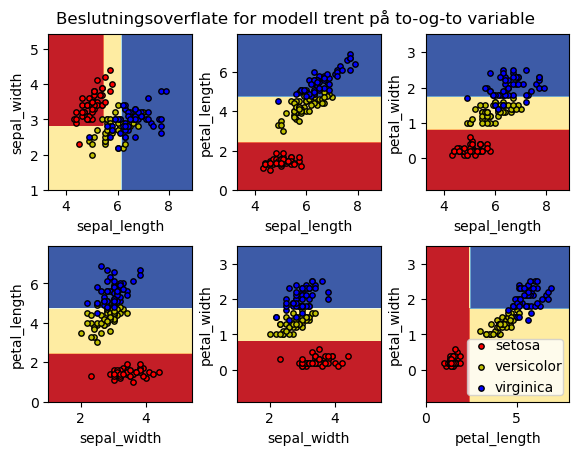

In [15]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

clf = []

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X_fit = X[:, pair]
    y = df.target

    # Train
    clf.append(tree.DecisionTreeClassifier(max_depth=2).fit(X_fit, Y))

    # Plot the decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5);
    DecisionBoundaryDisplay.from_estimator(
        clf[-1],
        X_fit,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=predictors[pair[0]],
        ylabel=predictors[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(Y == i)
        plt.scatter(
            X_fit[idx, 0],
            X_fit[idx, 1],
            c=color,
            label=df['species'].unique().tolist()[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        );
plt.suptitle("Beslutningsoverflate for modell trent på to-og-to variable");
plt.legend(loc="lower right", borderpad=0, handletextpad=0);
_ = plt.axis("tight");

La oss se på de tilsvarende beslutningstrærne 

/tmp/ipykernel_1898/3104118338.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=0.1)


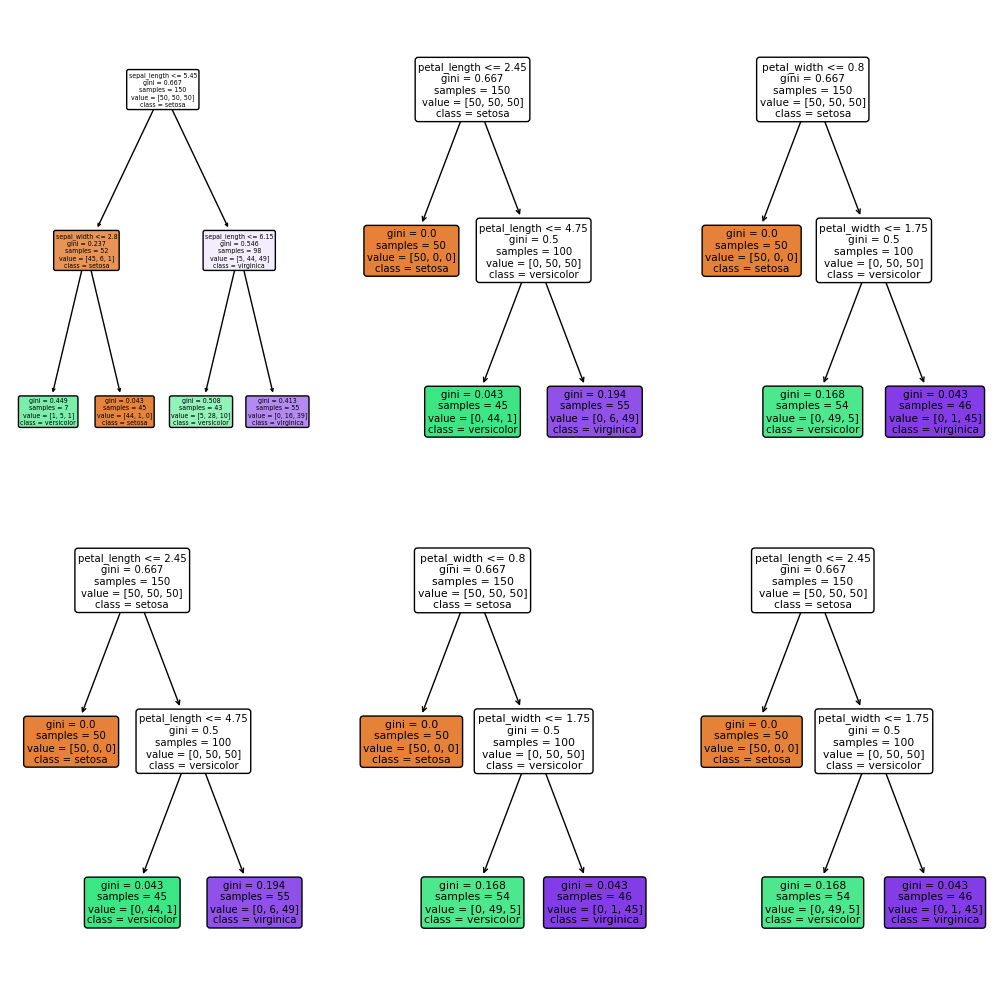

In [16]:
i = 0
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    #ax = plt.subplot(2, 3, pairidx+1)
    plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=0.1)
    tree.plot_tree(clf[pairidx], ax=ax.ravel()[pairidx], filled=True, class_names=df.species.unique().tolist(),feature_names=[predictors[pair[0]],predictors[pair[1]]],rounded=True);
    i += 1

## Beslutningstrær for regresjon

Beslutningstrær kan også brukes til regresjon (på samme måte som vi brukte lineær regresjon). Hvis dere husker så prøvde vi å lage en lineær regresjonsmodell for å finne en sammenheng mellom lengden og bredden til ulike typer blader hos ulike type iris. La oss se på iris-setosa (slik vi gjorde 

In [17]:
X_setosa_sepal_length = df[df["species"] == "setosa"].sepal_length.to_numpy()
X_setosa_sepal_width = df[df["species"] == "setosa"].sepal_width.to_numpy()
X_setosa_sepal_length = X_setosa_sepal_length[:, np.newaxis]
X_setosa_sepal_width = X_setosa_sepal_width[:, np.newaxis]

Vi bruker nå *DecisionTreeRegressor* for å gjøre en regresjonsanalyse

In [18]:
clf = tree.DecisionTreeRegressor(max_depth=3)
clf = clf.fit(X_setosa_sepal_length,X_setosa_sepal_width)

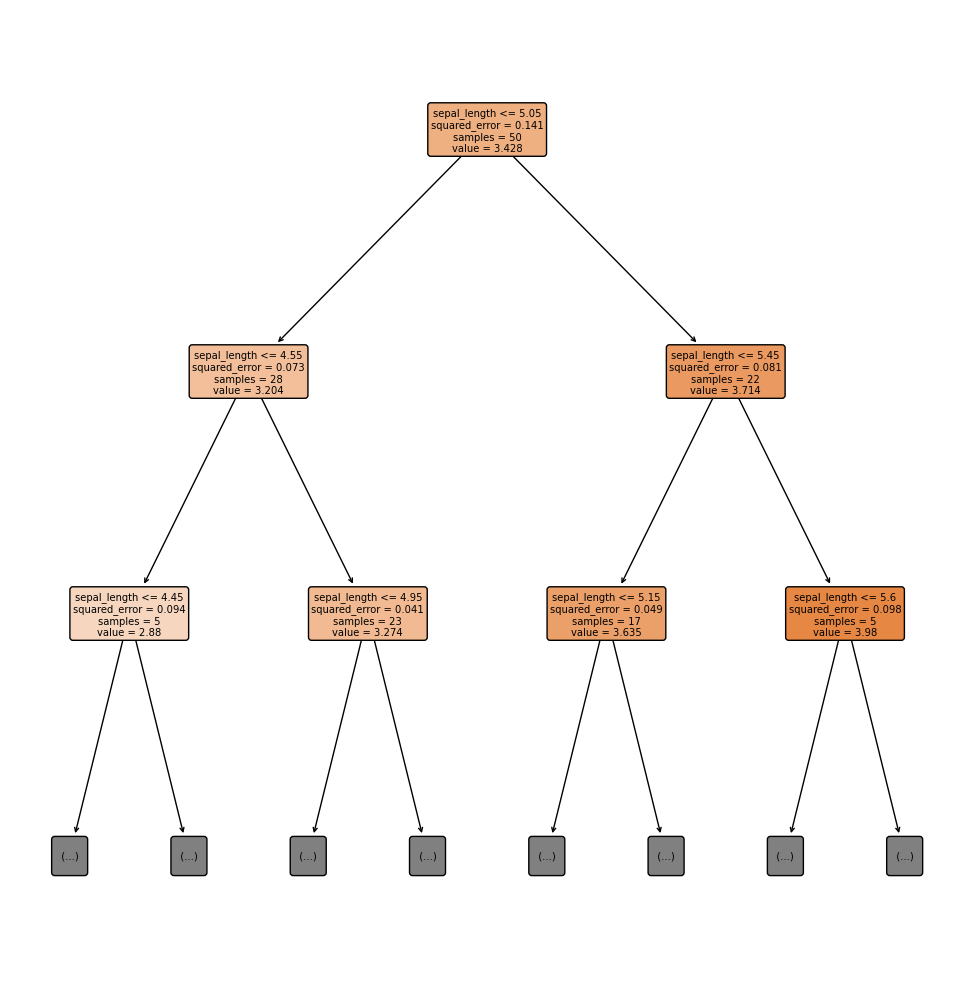

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=0.1)
tree.plot_tree(clf, max_depth=2,filled=True, feature_names=["sepal_length","sepal_width"],rounded=True,impurity=True);

Vi lager også en enkel lineær regresjonsmodell for å sammenlikne med det vi får fra å bruke beslutningstrær.

In [20]:
linmod = LinearRegression().fit(X_setosa_sepal_length,X_setosa_sepal_width)
X_plot = np.linspace(4, 7, 300)
fit = linmod.intercept_[0] + linmod.coef_[0]*X_plot

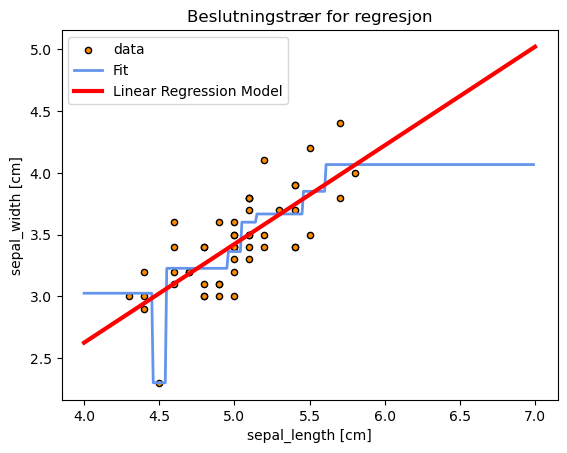

In [21]:
X_reg_test = np.arange(4.0, 7.0, 0.01)[:, np.newaxis]
y_reg_test = clf.predict(X_reg_test)

# Plot the results
plt.figure()
plt.scatter(X_setosa_sepal_length, X_setosa_sepal_width, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_reg_test, y_reg_test, color="cornflowerblue",
         label="Fit", linewidth=2)
plt.plot(X_plot, fit, label="Linear Regression Model", color="red", linewidth=3)
plt.xlabel("sepal_length [cm]")
plt.ylabel("sepal_width [cm]")
plt.title("Beslutningstrær for regresjon")
plt.legend()
plt.show()

Her ser vi flere svakheter ved beslutningstrær effektivt demonstrert

* Følsom for tilfeldige fluktuasjoner (over-trening) - modellen er dårlig til å generalisere
* Ustabil og skjør: små variasjoner i treningsdataene kan føre til helt forskjellige trær 

Hvordan vil modellen se ut for ulike dypder på treet?

In [22]:
clf = []
for depth in range(1,10,2):
    clf.append(tree.DecisionTreeRegressor(max_depth=depth))
    clf[-1].fit(X_setosa_sepal_length,X_setosa_sepal_width)

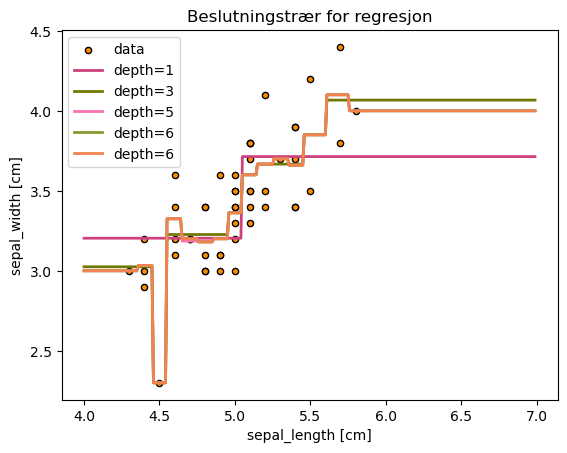

In [23]:
# Plot the results
fig, ax = plt.subplots()
plt.scatter(X_setosa_sepal_length, X_setosa_sepal_width, s=20, edgecolor="black",c="darkorange", label="data")
for i in range(len(clf)):
    y_reg_test = clf[i].predict(X_reg_test)
    plt.plot(X_reg_test, y_reg_test, color=np.random.rand(3,),
             label="depth=%i"%clf[i].tree_.max_depth, linewidth=2)
plt.xlabel("sepal_length [cm]")
plt.ylabel("sepal_width [cm]")
plt.title("Beslutningstrær for regresjon")
plt.legend()
plt.show()

### Hvordan bestemmer treet hvor det skal splitte?

I tilfellet med regresjon så gir det ikke mening å bruke gini-indeksen (siden vi ikke har noen kategorisering) for å splitte nodene. Vi ser derimot at *squared error* brukes. 

La oss prøve å forstå hvordan treet avgjør hvordan det velger å splitte. For enkelhets skyld så lager vi et enda enklere (dummy) datasett som gir en sammenheng mellom tidsbruk og karakter i et fag ved universitetet.

| Tid | Karakter |
| --- | --- | 
| 16 | 1.1 | 
| 20 | 1.2 | 
| 23 | 3.1 | 
| 29 | 2.8 | 
| 32 | 3.2 | 
| 39 | 1.3 | 
| 44 | 1.1 | 

La oss starte med å putte det inn i en numpy array direkte.

In [24]:
bdt = np.array([[16,1.1],[20,1.2],[23,3.1],[29,2.8],[32,3.2],[39,1.3],[44,1.1]])

Beslutningstrær prøver å dele opp dataene i områder basert på verdien til predikatorene og har som mål å lage områder som mimimerer RSS (residual sum of squares) definert ved

$$\sum_{j=1}^{J}\sum_{i\in R_j}\left(y_i - \hat{y}_{R_j}\right)^2$$

hvor vi nå har delt opp dataene i $J$ ulike områder, $R_1, R_2,...R_J$ og hvor $\hat{y}_{R_j}$ er gjennomsnittet av målingene i område $R_j$. Treet starter med en top-down tilnærming som starter på toppen av treet og finner den beste splitten uten å tenke på om det er gunstige for fremtidige splitter lengre ned i treet. Dette er kjent som **greedy** eller **recursive binary splitting**. La oss se om vi kan klare å predikere den første splitten til et beslutningtre på datasettet over. Dersom vi bare konsentrerer oss om første splitt forenkles uttrykket over siden vi kun da kun vil ha $2$ områder etter splitten. Vi vil altså minimere følgende uttrykk:

$$\sum_{i: x_i \in R_1}\left(y_i-\hat{y}_{R_1}\right)^2 + \sum_{i: x_i \in R_2}\left(y_i-\hat{y}_{R_2}\right)^2$$

Vi går gjennom dette på tavla, men en numerisk implementering av dette kan f.eks. se slik ut

In [25]:
mn = bdt.mean(axis=0)[1]
print(mn)

1.9714285714285713


In [26]:
mn = bdt.mean(axis=0)[1]
rss = 0
# Loop over alle muligheter for å splitte
for j in range(1,bdt.shape[0]):
    rss_R1 = 0
    rss_R2 = 0
    mean_R1 = bdt[0:j,:].mean(axis=0)[1]
    mean_R2 = bdt[j:,:].mean(axis=0)[1]
    n_R1 = 0
    n_R2 = 0
    # For hver mulighet til å splitte datasettet 
    # må vi regne ut de to summene i uttrykket over
    for i in range(bdt.shape[0]):
        if i < j:
            #print("In R1 and i = %i"%i)
            rss_R1 += (bdt[i][1]-mean_R1)**2
            n_R1 += 1
        else:
            #print("In R2 and i = %i"%i)
            rss_R2 += (bdt[i][1]-mean_R2)**2
            n_R2 += 1
    # Vi definerer kuttet til å være midt mellom de respektive målingene
    print("Dersom vi kutter ved tid = %.1f blir RSS1 (%.3f) + RSS2 (%.3f) = %.1f"%((bdt[j-1][0]+bdt[j][0])/2.,rss_R1/n_R1,rss_R2/n_R2,rss_R1+rss_R2))

Dersom vi kutter ved tid = 18.0 blir RSS1 (0.000) + RSS2 (0.858) = 5.1
Dersom vi kutter ved tid = 21.5 blir RSS1 (0.002) + RSS2 (0.828) = 4.1
Dersom vi kutter ved tid = 26.0 blir RSS1 (0.847) + RSS2 (0.835) = 5.9
Dersom vi kutter ved tid = 30.5 blir RSS1 (0.823) + RSS2 (0.896) = 6.0
Dersom vi kutter ved tid = 35.5 blir RSS1 (0.870) + RSS2 (0.010) = 4.4
Dersom vi kutter ved tid = 41.5 blir RSS1 (0.858) + RSS2 (0.000) = 5.1


Vi kan enkelt sjekke om dette stemmer ved å lage en regresjonsmodell for å predikere karakter fra tiden brukt i faget. For enkelhetsskyld tvinger vi treet til kun å utføre første split (*max_depth = 1*), men resultatet for første split vil være det samme uavhengig av dypbden på treet siden det er *greedy*. 

In [27]:
clf = tree.DecisionTreeRegressor(max_depth=1,criterion='squared_error')
X = bdt[:,0]
X = X[:, np.newaxis]
Y = bdt[:,1]
clf = clf.fit(X,Y)

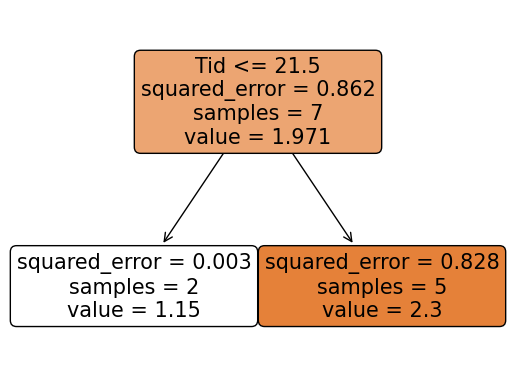

In [28]:
tree.plot_tree(clf, filled=True, feature_names=["Tid","Karakter"],rounded=True,impurity=True);

Stemmer perfekt med vår antagelse! Vi ser også at treet gir *squared error* for datasettet i hver region som den har laget. Dette sier noe om variasjonen i målingene innenfor de ulike regionene og er gitt ved

$$\frac{1}{N_{R_j}}\sum_{i \in R_j}\left(y_i-\hat{y}_{R_j}\right)^2$$

hvor altså $\hat{y}_{R_j}$ er gjennomsnittet av målingene i område $R_j$ og $N_{R_j}$ er antall målinger i det samme området. Første node har en realtivt stor feil ($0.862$) mens vi ser at de neste nodene har lavere feil (selvom feilen til den høyre noden fortsatt er ganske stor og nok vil bli delt opp i flere noder dersom vi gir treet anledning til å vokse videre). Vi kan enkelt regne ut *squared error* for den første noden.

In [29]:
sr = 0
n = 0
for i in range(bdt.shape[0]):
    sr += (bdt[i][1]-mn)**2
    n += 1
print(sr/7)

0.8620408163265306
